In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys

In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Loading Dataset

In [3]:
x_train,y_train= tfds.as_numpy(tfds.load('colorectal_histology', split='train[:80%]', batch_size=-1, as_supervised=True))
x_valid,y_valid= tfds.as_numpy(tfds.load('colorectal_histology', split='train[80:85%]', batch_size=-1, as_supervised=True))
x_test, y_test = tfds.as_numpy(tfds.load('colorectal_histology', split='train[85%:]', batch_size=-1, as_supervised=True))

In [4]:
from Training import create_iterators
classes      = 8
Train_bs     = 32
Inference_bs = 32
train_dataset,valid_dataset,test_dataset = create_iterators((x_train, y_train),(x_valid, y_valid),(x_test,  y_test),
                                                             Nclasses = classes, T_Bs = Train_bs, I_Bs = Inference_bs,
                                                             shape=(224,224))

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Creating Model

In [5]:
from Nets import VGG16_body

input_layer   = tf.keras.Input((224,224,3))
output_layer  = VGG16_body(input_layer, Quantization=False, Errors=False, N_labels = classes)
VGG16  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
# Optimization params
# -------------------
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
# Compile Model
VGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(VGG16, show_shapes=True)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [16]:
early_stop = True
callbacks = []

# Early Stopping
# --------------
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    callbacks.append(es_callback)


In [17]:
VGG16.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(x_train.shape[0] / Train_bs)),
          validation_data=valid_dataset,
          validation_steps=int(np.ceil(x_valid.shape[0] / Train_bs)), 
          callbacks=callbacks)

Epoch 1/100
  2/125 [..............................] - ETA: 24s - loss: 2.0799 - accuracy: 0.1875WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1149s vs `on_train_batch_end` time: 0.2901s). Check your callbacks.


125/125 [==============================] - 52s 414ms/step - loss: 1.8089 - accuracy: 0.2087 - val_loss: 1.5924 - val_accuracy: 0.3000
Epoch 2/100
125/125 [==============================] - 52s 413ms/step - loss: 1.4738 - accuracy: 0.3402 - val_loss: 1.4403 - val_accuracy: 0.3760
Epoch 3/100
125/125 [==============================] - 52s 413ms/step - loss: 1.2400 - accuracy: 0.4500 - val_loss: 0.9597 - val_accuracy: 0.5840
Epoch 4/100
125/125 [==============================] - 52s 413ms/step - loss: 0.9183 - accuracy: 0.6110 - val_loss: 0.8576 - val_accuracy: 0.6600
Epoch 5/100
125/125 [==============================] - 51s 409ms/step - loss: 0.7975 - accuracy: 0.6825 - val_loss: 0.9338 - val_accuracy: 0.6320
Epoch 6/100
125/125 [==============================] - 52s 413ms/step - loss: 0.7031 - accuracy: 0.7260 - val_loss: 0.6432 - val_accuracy: 0.7640
Epoch 7/100
125/125 [==============================] - 51s 409ms/step - loss: 0.6137 - accuracy: 0.7573 - val_loss: 0.7556 - val_accurac

In [33]:
(OrigLoss,OrigAcc) = VGG16.evaluate(test_dataset)

24/24 [==============================] - 3s 106ms/step - loss: 0.5084 - accuracy: 0.8053


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Save Weigths

In [6]:
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd, 'Data')
Wgt_dir = os.path.join(Wgt_dir, 'Trained Weights')
Wgt_dir = os.path.join(Wgt_dir, 'VGG16')
Wgt_dir = os.path.join(Wgt_dir, 'Colorectal Dataset')
Wgt_dir = os.path.join(Wgt_dir,'Weights')
VGG16.load_weights(Wgt_dir)

# 2) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [22]:
from Quantization_and_Errors import Check_Accuracy_and_Loss

# Showing accuracy with a heurisitc value of cuantization with no decrease in performance
Check_Accuracy_and_Loss('VGG16', test_dataset, Wgt_dir, N_labels = 8, IShape = (224,224,3),
                         Afrac_size = 9, Aint_size = 9, Wfrac_size = 11, Wint_size = 9);

24/24 [==============================] - 5s 210ms/step - loss: 0.5307 - accuracy: 0.8053


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Activation Fractional Number of Bits

In [35]:
E1_bits      = [1,2,3,4,5,6,7,8,9,10]
E1_acc       = [None]*10
E1_loss      = [None]*10
for index in range(0,10):
    (E1_acc[index],E1_loss[index]) = Check_Accuracy_and_Loss(model = 'VGG16', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   = E1_bits[index], Aint_size   = 9,
                                                             Wfrac_size   =             11, Wint_size   = 9)

24/24 [==============================] - 5s 211ms/step - loss: 0.5191 - accuracy: 0.8067


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Activation Integer Number of Bits

In [24]:
E2_bits      = [0,1,2,3,4,5,6,7,8]
E2_acc       = [None]*9
E2_loss      = [None]*9
for index in range(0,9):
    (E2_acc[index],E2_loss[index]) = Check_Accuracy_and_Loss(model = 'VGG16', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =  9, Aint_size   = E2_bits[index],
                                                             Wfrac_size   = 11, Wint_size   =              9)

24/24 [==============================] - 5s 211ms/step - loss: 0.5307 - accuracy: 0.8053


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Weights Fractional Number of Bits

In [25]:
E3_bits      = [4,5,6,7,8,9,10,11,12,13]
E3_acc       = [None]*10
E3_loss      = [None]*10
for index in range(0,10):
    (E3_acc[index],E3_loss[index]) = Check_Accuracy_and_Loss(model = 'VGG16', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =              9, Aint_size = 9,
                                                             Wfrac_size   = E3_bits[index], Wint_size = 9)

24/24 [==============================] - 5s 212ms/step - loss: 0.5314 - accuracy: 0.8053


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Weights Integer Number of Bits

In [26]:
E4_bits      = [0,1,2,3,4,5,6,7,8]
E4_acc       = [None]*9
E4_loss      = [None]*9
for index in range(0,9):
    (E4_acc[index],E4_loss[index]) = Check_Accuracy_and_Loss(model = 'VGG16', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =  9, Aint_size =             9,
                                                             Wfrac_size   = 11, Wint_size = E4_bits[index])

24/24 [==============================] - 5s 212ms/step - loss: 0.5307 - accuracy: 0.8053


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Best Config

In [32]:
Check_Accuracy_and_Loss(model = 'VGG16', test_dataset = test_dataset, Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                        Afrac_size = 6, Aint_size = 3, Wfrac_size = 11, Wint_size = 0);

24/24 [==============================] - 5s 209ms/step - loss: 0.5471 - accuracy: 0.8000


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Plotting Results

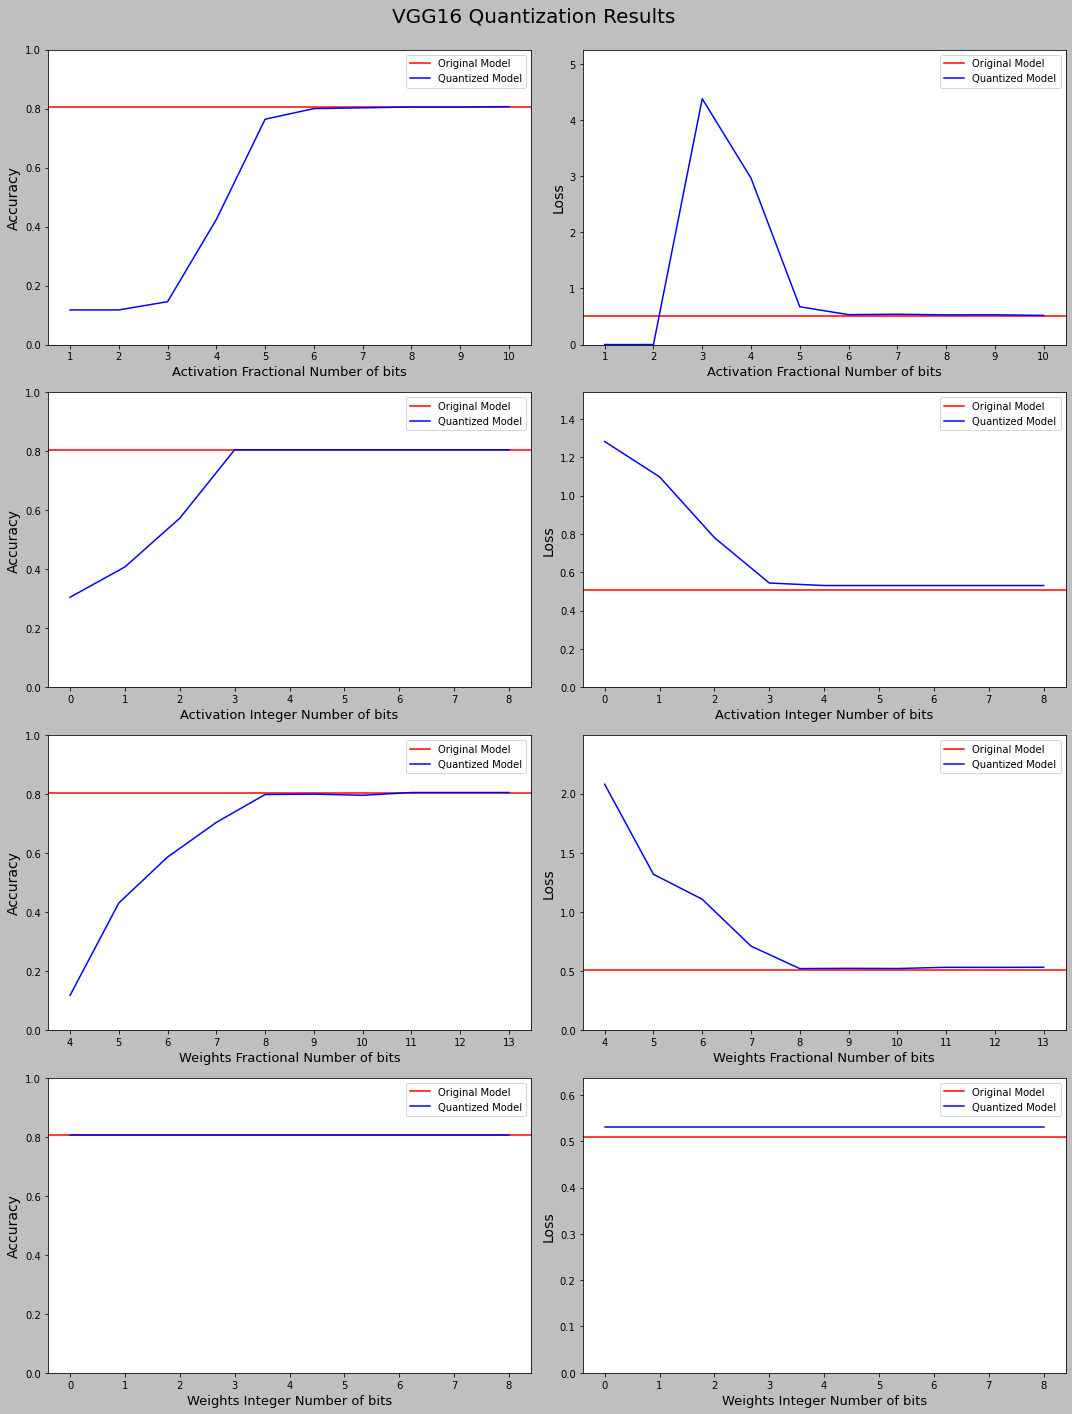

In [36]:
from Plots import Plot_4Experiments

Qbits   = [E1_bits,E2_bits,E3_bits,E4_bits]
Accs    = [E1_acc,E2_acc,E3_acc,E4_acc]
Losses  = [E1_loss,E2_loss,E3_loss,E4_loss]
xlabels = ['Activation Fractional Number of bits', 'Activation Integer Number of bits',
                       'Weights Fractional Number of bits',   'Weights Integer Number of bits' ]

Plot_4Experiments('VGG16', Qbits, Accs, Losses, OrigAcc, OrigLoss, xlabels, figsize = (15,20), save_fig = True,
                 fig_dir = 'Figures/Quantization Experiments/VGG16/Colorectal Dataset/Weights/')

# 3) Buffer Simulation

In [10]:
from Training import create_iterators
classes      = 8
Inference_bs = 1
_,_,test_dataset = create_iterators(None,None,(x_test,  y_test), Nclasses = classes, I_Bs = Inference_bs, shape=(224,224))
del x_train,y_train,x_valid,y_valid

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Load Quantized Model

In [9]:
from Nets import VGG16_body
from Quantization_and_Errors import Weight_Quantization

Qinput_layer   = tf.keras.Input((224,224,3))
Qoutput_layer  = VGG16_body(Qinput_layer, Quantization = True, Errors = False, N_labels=8, word_size = 10, frac_size = 6)
QVGG16         = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)
# Optimization params
# -------------------
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
# Compile Model
QVGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QVGG16.load_weights(Wgt_dir)
Weight_Quantization(model = QVGG16, Frac_Bits = 11, Int_Bits = 0)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Simulate a portion of the test dataset  through the buffers 

In [ ]:
from Simulation import save_obj
from tensorflow.python.keras import backend as K
def get_all_outputs(model, input_data, learning_phase=False):
    outputs = [layer.output for layer in model.layers] # exclude Input
    layers_fn = K.function([model.input], outputs)
    return layers_fn([input_data])

List = []
iterator   = iter(test_dataset)
index      = 0
while index < 200:
    image = next(iterator)[0]
    a = get_all_outputs(QVGG16,image)
    acts = [a[2],a[6],a[10],a[12],a[16],a[20],a[22],a[26],a[30],a[34],a[36],a[40],a[44],a[48],a[50],a[54],a[58],a[62],
            a[64],a[69],a[73],a[77]]
    List.append(acts)
    index+=1
save_obj(List,'Activations sampled/VGG16/Colorectal Dataset/Weights/200 samples')

In [ ]:
from Simulation import VGG16_Sim, save_obj, load_obj
from datetime import datetime

start_from_zero = False

if start_from_zero:
    # Bufferes
    IOBuffer_size = 3211264*10
    IOBuffer_1 = np.zeros(IOBuffer_size,dtype=np.int8)
    IOBuffer_2 = np.zeros(IOBuffer_size,dtype=np.int8)
    # Numero de ciclos en valor 1 por celda
    duty_1 = np.zeros(IOBuffer_size,dtype=np.uint32)
    duty_2 = np.zeros(IOBuffer_size,dtype=np.uint32)
    ciclos = 0
    start_from = 0
                    
else:
    duty_1 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/duty_B1')
    duty_2 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/duty_B2')
    ciclos = load_obj('Stats/VGG16/Colorectal Dataset/Weights/ciclos')
    IOBuffer_1 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/IOBuffer_1')
    IOBuffer_2 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/IOBuffer_2')
    start_from = 199

iterator   = iter(test_dataset)
index      = 1
batch_size = 200
while index <= batch_size:
    image = next(iterator)[0]
    if index > start_from:
        a = get_all_outputs(QVGG16,image)
        acts = [a[2],a[6],a[10],a[12],a[16],a[20],a[22],a[26],a[30],a[34],a[36],a[40],a[44],a[48],a[50],a[54],a[58],a[62],
                a[64],a[69],a[73],a[77]]
        del a
        if index % 2 == 0:
            ciclos += VGG16_Sim(acts, IOBuffer_1, duty_1, IOBuffer_2, duty_2, word_size = 10, frac_size = 6)
        else:
            ciclos += VGG16_Sim(acts, IOBuffer_2, duty_2, IOBuffer_1, duty_1, word_size = 10, frac_size = 6)
        save_obj(duty_1,'Stats/VGG16/Colorectal Dataset/Weights/duty_B1')
        save_obj(duty_2,'Stats/VGG16/Colorectal Dataset/Weights/duty_B2')
        save_obj(ciclos,'Stats/VGG16/Colorectal Dataset/Weights/ciclos')
        save_obj(IOBuffer_1,'Stats/VGG16/Colorectal Dataset/Weights/IOBuffer_1')
        save_obj(IOBuffer_2,'Stats/VGG16/Colorectal Dataset/Weights/IOBuffer_2')
        print('imagenes procesadas:',index,' tiempo:',datetime.now().strftime("%H:%M:%S"),'ciclos: ',ciclos)
    index = index + 1

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Plotting Heatmaps 

In [1]:
from Simulation import load_obj

ciclos = load_obj('Stats/VGG16/Colorectal Dataset/Weights/ciclos')
duty_1 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/duty_B1')
duty_2 = load_obj('Stats/VGG16/Colorectal Dataset/Weights/duty_B2')

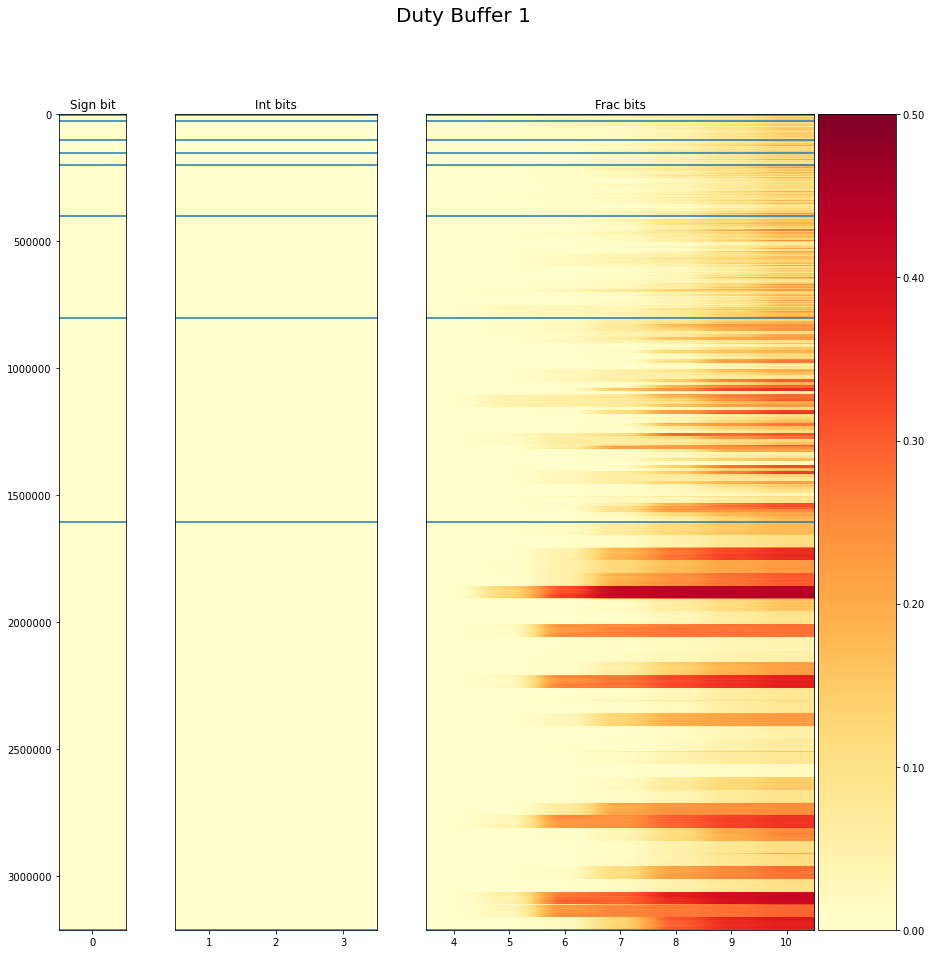

In [71]:
from Plots import plot_duty
plot_duty(duty_1, ciclos, 'Duty Buffer 1, tras 200 imagenes', low=0, high=3211264, mode = 'Duty',
          figsize = (15,15), bits_dist=[1,3,6], threshold = None,
          save_fig = False, fig_dir='Figures/Buffer Heatmaps/VGG16/Colorectal Dataset/Weights/Duty Buffer 1',
          sections_boundaries = [4096,25088,100352,150528,200704,401408,802816,1605632,3211264])

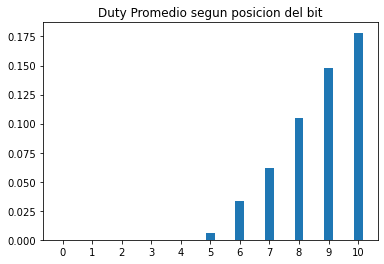

In [148]:
import matplotlib.pyplot as plt

data   = load_obj('Stats/VGG16/Colorectal Dataset/Weights/duty_B1').astype(np.uint64)
ciclos = load_obj('Stats/VGG16/Colorectal Dataset/Weights/ciclos').astype(np.uint64)
data   = np.reshape(data,(3211264,10))
data   = np.sum(data,axis=0)/(ciclos*3211264)
data   = np.reshape(data,(1,-1))

plt.figure(figsize=(15,5))
plt.title('VGG16: Duty Promedio segun posicion del bit tras 200 imagenes inferidas')
fig = plt.bar(['0','1','2','3','4','5','6','7','8','9'],data[0],0.3)
plt.xlabel('Bit Position 0: Sign, 1-3: Integer part, 4-9: Fractional part',fontsize=13)
plt.ylabel('Duty',fontsize=13)
plt.savefig('Figures/Buffer Heatmaps/VGG16/Colorectal Dataset/Weights/Duty per bit position')

# 4) Error Injection

In [ ]:
from Training import create_iterators

classes      = 8
Inference_bs = 16
_,_,test_dataset = create_iterators(None,None,(x_test,  y_test), Nclasses = classes, I_Bs = Inference_bs, shape=(224,224))
del x_train,y_train,x_valid,y_valid

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Measuring effect of errors by buffer,section,number of faults and bit localization of the fault

In [ ]:
from copy import deepcopy
from Quantization_and_Errors import Check_Accuracy_and_Loss
from Simulation import save_obj, load_obj
from datetime import datetime

Start_from_zero = True

if Start_from_zero:
    tmp_dict = {0.001:[],0.01:[],0.1:[],0.2:[]}  #Portions to test in each section
    tmp_dict = {'Buffer 1': {'Addresses 0-4096': deepcopy(tmp_dict),
                             'Addresses 4096-100352': deepcopy(tmp_dict),
                             'Addresses 100352-401408': deepcopy(tmp_dict),
                             'Addresses 401408-802816': deepcopy(tmp_dict),
                             'Addresses 802816-3211264': deepcopy(tmp_dict) },            
                'Buffer 2': {'Addresses 0-4096': deepcopy(tmp_dict),
                             'Addresses 4096-100352': deepcopy(tmp_dict),
                             'Addresses 100352-401408': deepcopy(tmp_dict),
                             'Addresses 401408-802816': deepcopy(tmp_dict),
                             'Addresses 802816-3211264': deepcopy(tmp_dict)}}
    Accs     = {'2nd bit':deepcopy(tmp_dict),'3rd bit':deepcopy(tmp_dict)}
    Loss     = {'2nd bit':deepcopy(tmp_dict),'3rd bit':deepcopy(tmp_dict)}
else:
    Accs     = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Accsf')
    Loss     = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Lossf')


Mapping   = {'Buffer 1':[True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,
                        False,True,False,True],
             'Buffer 2':[False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,
                        False,True,False,True,False],
             'Addresses 0-4096'          : (range(0,4096)          ,4096),   #Range and Len of each section
             'Addresses 4096-100352'     : (range(4096,100352)     ,96256),  
             'Addresses 100352-401408'   : (range(100352,401408)   ,301056),
             'Addresses 401408-802816'   : (range(401408,802816)   ,401408),
             'Addresses 802816-3211264'  : (range(802816,3211264)  ,2408448),
             '1st bit': ['1xxxxxxxxx'], # mask of the error
             '2nd bit': ['x1xxxxxxxx'],
             '3rd bit': ['xx1xxxxxxx']}

Num_of_samples = 100
for bit_loc in Loss:
    for Buffer in Loss[bit_loc]:
        for section in Loss[bit_loc][Buffer]:
            for Enumber in Loss[bit_loc][Buffer][section]:
                for index in range(0,Num_of_samples):
                    number_of_errors = np.ceil(Enumber*Mapping[section][1]).astype(int)
                    locs = np.random.choice(Mapping[section][0],number_of_errors,False)
                    acc,loss = Check_Accuracy_and_Loss('VGG16', test_dataset, Wgt_dir, N_labels=classes, IShape = (224,224,3),
                                                        Afrac_size = 6, Aint_size = 3, Wfrac_size = 11, Wint_size = 0,
                                                        Bs=Inference_bs, verbose = 0, Layer_Error_mask = Mapping[Buffer],
                                                        locations = locs, errors = Mapping[bit_loc]*number_of_errors)
                    
                    Accs[bit_loc][Buffer][section][Enumber].append(acc)
                    Loss[bit_loc][Buffer][section][Enumber].append(loss)
                print(bit_loc+', '+Buffer+', '+section+', '+str(Enumber)+' completada: ',
                      datetime.now().strftime("%H:%M:%S"))
                save_obj(Accs,'Errors/VGG16/Colorectal Dataset/Weights/Accsf')
                save_obj(Loss,'Errors/VGG16/Colorectal Dataset/Weights/Lossf')

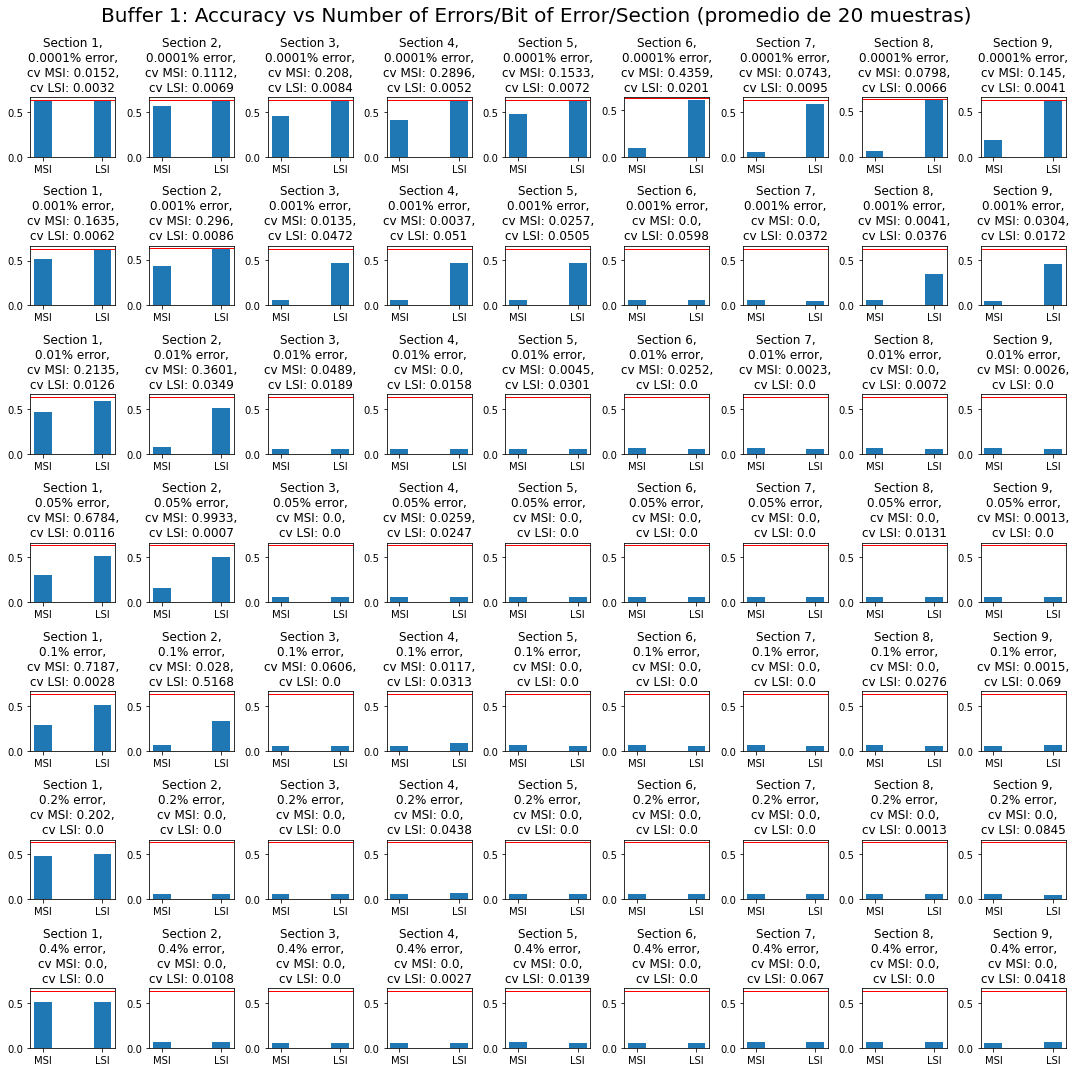

In [7]:
from Plots import Plot_Errors
from Simulation import load_obj

DataDicts = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264'],
            ['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264']]
keys1    = ['2nd bit','3rd bit']
keys2    = ['Buffer 1','Buffer 2']

OrigAcc     = 0.8000
OrigLss     = 0.5471

Plot_Errors(DataDicts, Sections, keys1, keys2, OrigAcc, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of addresses under failure', BoxPlot = False,  Scaled_max_value= None, ylabel = 'Accuracy',
            fig_dir = 'Figures/Errors/VGG16/Colorectal Dataset/Weights/Accuracy')

In [ ]:
DataDicts = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264'],
            ['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264']]
keys1    = ['2nd bit','3rd bit']
keys2    = ['Buffer 1','Buffer 2']

OrigAcc     = 0.8000
OrigLss     = 0.5471

Plot_Errors(DataDicts, Sections, keys1, keys2, OrigAcc, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of addresses under failure', BoxPlot = True,  Scaled_max_value= None, ylabel = 'Accuracy',
            fig_dir = 'Figures/Errors/VGG16/Colorectal Dataset/Weights/Accuracy Boxplot')

In [ ]:
DataDicts = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264'],
            ['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264']]
keys1    = ['2nd bit','3rd bit']
keys2    = ['Buffer 1','Buffer 2']

OrigAcc     = 0.8000
OrigLss     = 0.5471

Plot_Errors(DataDicts, Sections, keys1, keys2, OrigLss, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of addresses under failure', BoxPlot = False,  Scaled_max_value= None, ylabel = 'Loss',
            fig_dir = 'Figures/Errors/VGG16/Colorectal Dataset/Weights/Loss')

In [ ]:
DataDicts = load_obj('Errors/VGG16/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264'],
            ['Addresses 0-4096',  'Addresses 4096-100352', 'Addresses 100352-401408', 'Addresses 401408-802816','Addresses 802816-3211264']]
keys1    = ['2nd bit','3rd bit']
keys2    = ['Buffer 1','Buffer 2']

OrigAcc     = 0.8000
OrigLss     = 0.5471

Plot_Errors(DataDicts, Sections, keys1, keys2, OrigLss, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of addresses under failure', BoxPlot = True,  Scaled_max_value= None, ylabel = 'Loss',
            fig_dir = 'Figures/Errors/VGG16/Colorectal Dataset/Weights/Loss Boxplot')